## Abstract

El presente análisis busca explorar los factores que influyen en el rendimiento académico de los estudiantes a partir de un dataset con 10,000 observaciones. Se analizan variables como horas de estudio, uso de tecnología educativa, nivel de estrés, asistencia y estilo de aprendizaje. 

El objetivo principal es identificar patrones que puedan ayudar a mejorar la educación y determinar qué factores tienen mayor impacto en los puntajes de examen. Se plantean las siguientes preguntas: 
1. ¿Más horas de estudio garantizan mejores calificaciones?  
2. ¿Existe una relación entre el nivel de estrés y los puntajes de examen?  
3. ¿El uso de tecnología educativa tiene un impacto positivo en los resultados?  




## Preguntas de interés e Hipótesis

### 1 ¿Más horas de estudio garantizan mejores calificaciones?
**Hipótesis:** Los estudiantes que estudian más horas a la semana obtienen mejores puntajes en los exámenes.

### 2️ ¿Existe una relación entre el nivel de estrés y los puntajes de examen?
**Hipótesis:** Los estudiantes con un nivel de estrés más alto tienden a obtener menores puntajes en los exámenes.

### 3️ ¿El uso de tecnología educativa tiene un impacto positivo en los resultados?
**Hipótesis:** Los estudiantes que usan herramientas educativas en línea obtienen mejores calificaciones en promedio.


## Aclaración:

**El análisis exploratorio completo y las visualizaciones iniciales se encuentran en **ProyectoDSParteI+EspecheDario.ipynb**. Aquí nos centramos en selección de características y modelado predictivo.**


## Carga de datos y preparación

In [8]:
# 1.1  Importar librerías básicas
import pandas as pd
import numpy as np

# 1.2  Leer el archivo CSV (ruta relativa dentro del repo)
df = pd.read_csv("data/student_performance_large_dataset-checkpoint.csv")

# 1.3  Vista rápida para comprobar columnas y tipos
display(df.head())
display(df.info())

,Student_ID,Age,Gender,Study_Hours_per_Week,Preferred_Learning_Style,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate (%),Exam_Score (%),Attendance_Rate (%),Use_of_Educational_Tech,Self_Reported_Stress_Level,Time_Spent_on_Social_Media (hours/week),Sleep_Hours_per_Night,Final_Grade
0,S00001,18,Female,48,Kinesthetic,14,Yes,100,69,66,Yes,High,9,8,C
1,S00002,29,Female,30,Reading/Writing,20,No,71,40,57,Yes,Medium,28,8,D
2,S00003,20,Female,47,Kinesthetic,11,No,60,43,79,Yes,Low,13,7,D
3,S00004,23,Female,13,Auditory,0,Yes,63,70,60,Yes,Low,24,10,B
4,S00005,19,Female,24,Auditory,19,Yes,59,63,93,Yes,Medium,26,8,C


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Student_ID                               10000 non-null  object
 1   Age                                      10000 non-null  int64 
 2   Gender                                   10000 non-null  object
 3   Study_Hours_per_Week                     10000 non-null  int64 
 4   Preferred_Learning_Style                 10000 non-null  object
 5   Online_Courses_Completed                 10000 non-null  int64 
 6   Participation_in_Discussions             10000 non-null  object
 7   Assignment_Completion_Rate (%)           10000 non-null  int64 
 8   Exam_Score (%)                           10000 non-null  int64 
 9   Attendance_Rate (%)                      10000 non-null  int64 
 10  Use_of_Educational_Tech                  10000 non-null  ob

None

## Normalizar nombres de columnas

In [9]:
# pasar a snake_case para evitar espacios y caracteres especiales
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
      .str.replace("%", "pct")
)

## Separar variables numéricas y categóricas

In [10]:
target = "exam_score_(pct)"          # nueva versión del nombre
num_cols = df.select_dtypes(include="number").columns.drop(target)
cat_cols = df.select_dtypes(exclude="number").columns
print("Numéricas:", list(num_cols))
print("Categóricas:", list(cat_cols))


Numéricas: ['age', 'study_hours_per_week', 'online_courses_completed', 'assignment_completion_rate_(pct)', 'attendance_rate_(pct)', 'time_spent_on_social_media_(hours/week)', 'sleep_hours_per_night']
Categóricas: ['student_id', 'gender', 'preferred_learning_style', 'participation_in_discussions', 'use_of_educational_tech', 'self_reported_stress_level', 'final_grade']


## Diagnóstico y tratamiento de valores perdidos.

In [11]:
# Conteo de NAs
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts[na_counts > 0])

# Imputación sencilla
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# Verificación
print("NAs restantes:", df.isna().sum().sum())


Series([], dtype: int64)

NAs restantes: 0


## Variables diana (y) y de entrada (X)

In [12]:
X = df.drop(columns=[target])
y = df[target]

## Pipeline de preprocesado y selección de variables.
Objetivo: un solo objeto Pipeline que encapsule

1) Escalado/one‑hot. 
2) Selección de k mejores features. 
3) Modelo final.


In [13]:
# 2.1  Librerías de scikit-learn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor

# 2.2  Transformadores por tipo de dato
numeric_tf = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

categorical_tf = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# 2.3  Combinarlos en un ColumnTransformer
preprocess = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

# 2.4  Selección de características
#     - f_regression: test F entre cada feature y la variable continua y
#     - k = 20: nos quedamos con las 20 más informativas
selector = SelectKBest(score_func=f_regression, k=20)

# 2.5  Modelo de machine learning
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# 2.6  Pipeline completo
pipe = Pipeline(steps=[
    ("prep", preprocess),      # 1) escalado + one‑hot
    ("fs", selector),          # 2) SelectKBest
    ("model", model)           # 3) Random Forest
])

pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'study_hours_per_week', 'online_courses_completed',
       'assignment_completion_rate_(pct)', 'attendance_rate_(pct)',
       'time_spent_on_social_media_(hours/week)', 'sleep_hours_per_night'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHo...
                                                                                 sparse_output=False))]),
                                                  Index(['student_id', 'gender', 'preferred_learning_style',
       'participation_in_discussions', 'use_of_educational_tech',
       'self_reported_stress_level', 'final_grade'],
      dtype='object'))])),
                ('fs',
                 SelectKBest(k=20,
                             score_func=<function f_regression at 0x00000170A1B811C0>)),
                ('model',
                 RandomForestRegressor(n_estimators=300, n_jobs=-1,
                                       random_state=42))])

## Entrenamiento y evaluación del modelo.

In [14]:
## 3. Entrenamiento y evaluación 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

# 3.1  División train / test (80‑20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 3.2  Ajustar el pipeline
pipe.fit(X_train, y_train)

# 3.3  Predicciones en test
y_pred = pipe.predict(X_test)

# 3.4  Métricas básicas
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.3f}")

# 3.5  Validación cruzada (5‑fold)
cv_rmse = -cross_val_score(
    pipe, X, y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
).mean()

print(f"CV RMSE (5‑fold): {cv_rmse:.2f}")


MAE : 3.78
RMSE: 4.39
R²  : 0.938
CV RMSE (5‑fold): 4.44


## Importancia de variables seleccionadas

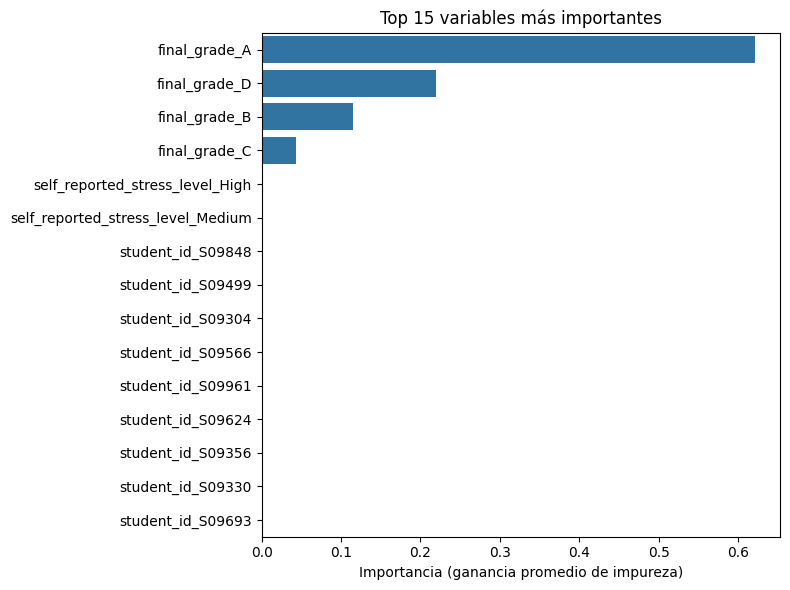

,feature,importance
16,final_grade_A,0.621514
19,final_grade_D,0.219344
17,final_grade_B,0.114807
18,final_grade_C,0.043884
14,self_reported_stress_level_High,0.000092
15,self_reported_stress_level_Medium,0.000068
10,student_id_S09848,0.000023
4,student_id_S09499,0.000022
0,student_id_S09304,0.000022
5,student_id_S09566,0.000022


In [ ]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns

# Recuperar nombres post‑one‑hot
ohe = pipe.named_steps["prep"].named_transformers_["cat"]["ohe"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols, cat_feature_names])

# Filtrar solo las kfeatures retenidas por SelectKBest
selected_mask = pipe.named_steps["fs"].get_support()
selected_names = all_feature_names[selected_mask]

# Importancias del RandomForest
importances = pipe.named_steps["model"].feature_importances_

# Crear DataFrame ordenado
imp_df = (pd.DataFrame({"feature": selected_names,
                        "importance": importances})
          .sort_values("importance", ascending=False)
          .head(15)                         # Top‑15
)

# Visualizar
plt.figure(figsize=(8,6))
sns.barplot(data=imp_df, y="feature", x="importance")
plt.title("Top 15 variables más importantes")
plt.xlabel("Importancia (ganancia promedio de impureza)")
plt.ylabel("")
plt.tight_layout()
plt.show()

imp_df
